# Pruning and Overfitting

Understanding and preventing overfitting in decision trees:
1. Demonstrating overfitting
2. Pre-pruning (early stopping)
3. Analyzing hyperparameter effects
4. Learning curves

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, make_moons
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.tree import DecisionTreeClassifier

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

---
## Part 1: Demonstrating Overfitting

In [2]:
# Generate noisy dataset
X, y = make_classification(n_samples=300, n_features=2, n_redundant=0,
                          n_informative=2, n_clusters_per_class=1,
                          flip_y=0.1, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(f'Training samples: {len(X_train)}')
print(f'Test samples: {len(X_test)}')

Training samples: 210
Test samples: 90


### Compare Shallow vs Deep Trees

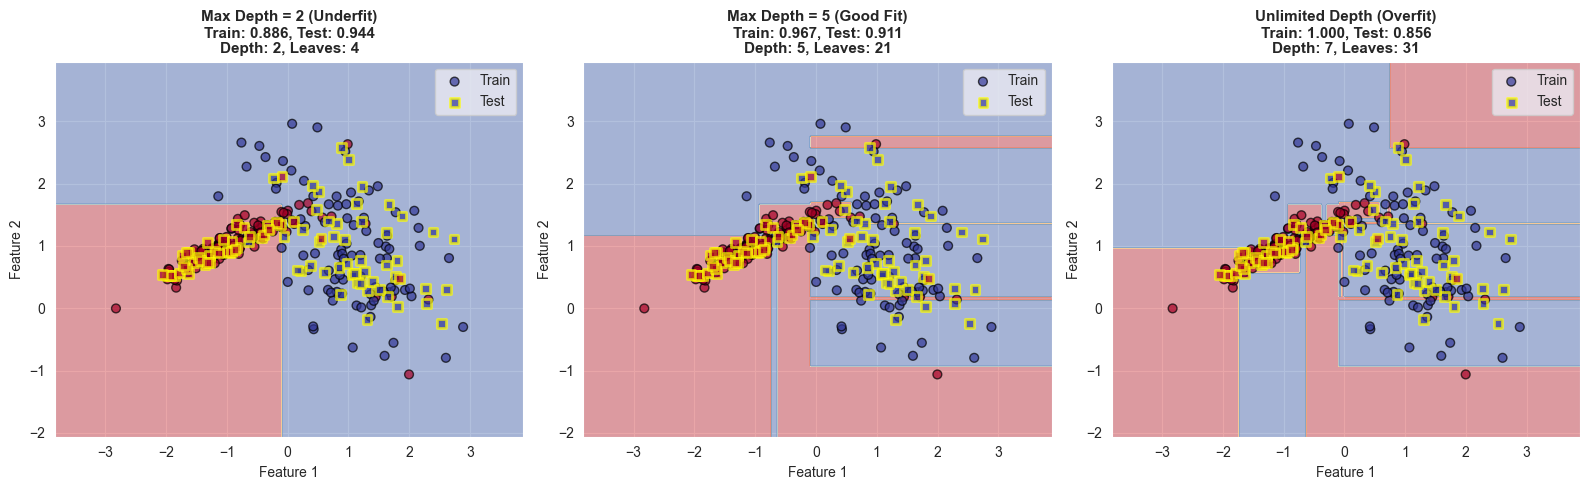

In [3]:
# Train trees with different depths
depths = [2, 5, None]  # None = unlimited depth
titles = ['Max Depth = 2 (Underfit)', 'Max Depth = 5 (Good Fit)', 'Unlimited Depth (Overfit)']

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, (depth, title) in enumerate(zip(depths, titles)):
    # Train tree
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    
    # Calculate accuracies
    train_acc = tree.score(X_train, y_train)
    test_acc = tree.score(X_test, y_test)
    
    # Create mesh for decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot
    axes[idx].contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')
    axes[idx].scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=40,
                     edgecolors='k', cmap='RdYlBu', alpha=0.7, label='Train')
    axes[idx].scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=40,
                     edgecolors='yellow', linewidths=2, cmap='RdYlBu', 
                     alpha=0.7, marker='s', label='Test')
    
    axes[idx].set_title(f'{title}\nTrain: {train_acc:.3f}, Test: {test_acc:.3f}\n' +
                       f'Depth: {tree.get_depth()}, Leaves: {tree.get_n_leaves()}',
                       fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Feature 1')
    axes[idx].set_ylabel('Feature 2')
    axes[idx].legend()

plt.tight_layout()
plt.show()

### Observation:
- **Depth = 2**: Simple boundary, underfits (low train/test accuracy)
- **Depth = 5**: Balanced complexity, good generalization
- **Unlimited depth**: Complex jagged boundary, overfits (train >> test)

---
## Part 2: Effect of Hyperparameters

### 2.1 Max Depth

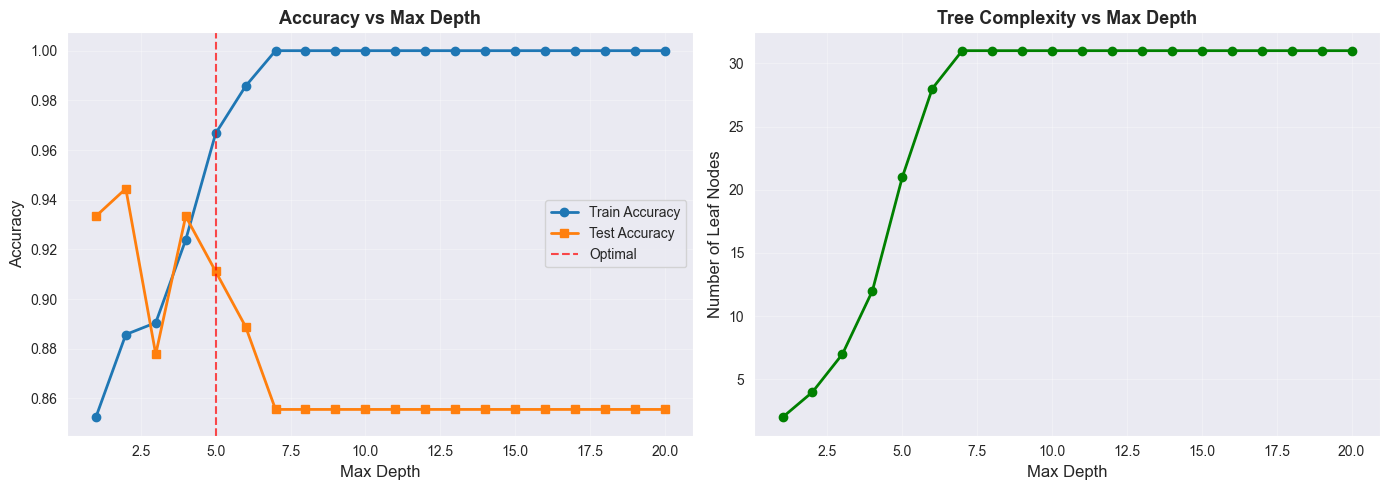

Optimal max_depth: 2
Test accuracy at optimal: 0.9444


In [4]:
depths_range = range(1, 21)
train_scores = []
test_scores = []
n_leaves = []

for depth in depths_range:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    
    train_scores.append(tree.score(X_train, y_train))
    test_scores.append(tree.score(X_test, y_test))
    n_leaves.append(tree.get_n_leaves())

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy vs depth
axes[0].plot(depths_range, train_scores, 'o-', label='Train Accuracy', linewidth=2)
axes[0].plot(depths_range, test_scores, 's-', label='Test Accuracy', linewidth=2)
axes[0].axvline(x=5, color='red', linestyle='--', alpha=0.7, label='Optimal')
axes[0].set_xlabel('Max Depth', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Accuracy vs Max Depth', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Number of leaves
axes[1].plot(depths_range, n_leaves, 'o-', linewidth=2, color='green')
axes[1].set_xlabel('Max Depth', fontsize=12)
axes[1].set_ylabel('Number of Leaf Nodes', fontsize=12)
axes[1].set_title('Tree Complexity vs Max Depth', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

optimal_depth = depths_range[np.argmax(test_scores)]
print(f'Optimal max_depth: {optimal_depth}')
print(f'Test accuracy at optimal: {max(test_scores):.4f}')

### 2.2 Min Samples Split

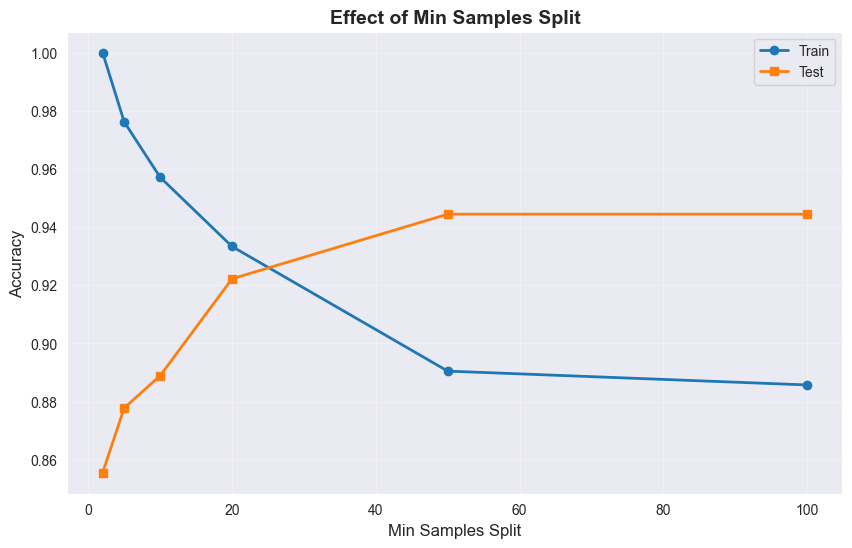

Higher min_samples_split → simpler tree → less overfitting


In [5]:
min_samples_range = [2, 5, 10, 20, 50, 100]
train_scores_split = []
test_scores_split = []

for min_samples in min_samples_range:
    tree = DecisionTreeClassifier(min_samples_split=min_samples, random_state=42)
    tree.fit(X_train, y_train)
    
    train_scores_split.append(tree.score(X_train, y_train))
    test_scores_split.append(tree.score(X_test, y_test))

plt.figure(figsize=(10, 6))
plt.plot(min_samples_range, train_scores_split, 'o-', label='Train', linewidth=2)
plt.plot(min_samples_range, test_scores_split, 's-', label='Test', linewidth=2)
plt.xlabel('Min Samples Split', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Effect of Min Samples Split', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print('Higher min_samples_split → simpler tree → less overfitting')

### 2.3 Min Samples Leaf

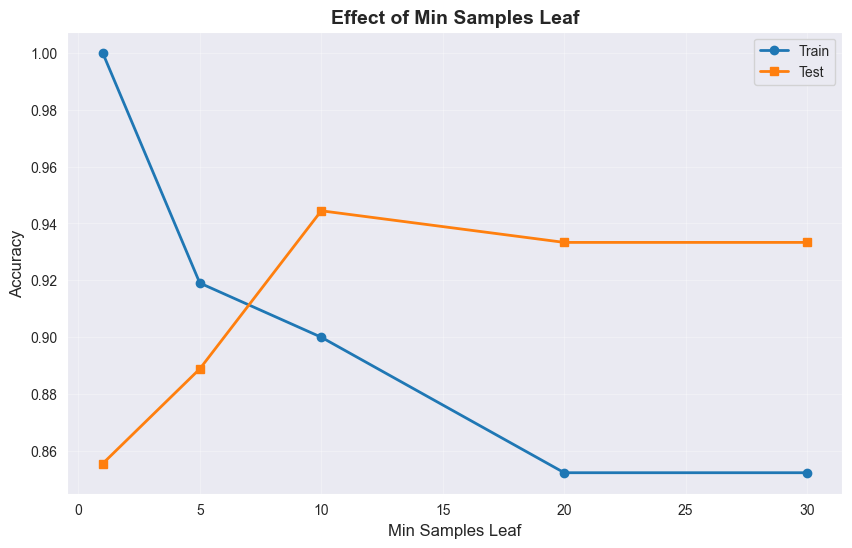

In [6]:
min_leaf_range = [1, 5, 10, 20, 30]
train_scores_leaf = []
test_scores_leaf = []

for min_leaf in min_leaf_range:
    tree = DecisionTreeClassifier(min_samples_leaf=min_leaf, random_state=42)
    tree.fit(X_train, y_train)
    
    train_scores_leaf.append(tree.score(X_train, y_train))
    test_scores_leaf.append(tree.score(X_test, y_test))

plt.figure(figsize=(10, 6))
plt.plot(min_leaf_range, train_scores_leaf, 'o-', label='Train', linewidth=2)
plt.plot(min_leaf_range, test_scores_leaf, 's-', label='Test', linewidth=2)
plt.xlabel('Min Samples Leaf', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Effect of Min Samples Leaf', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

---
## Part 3: Learning Curves

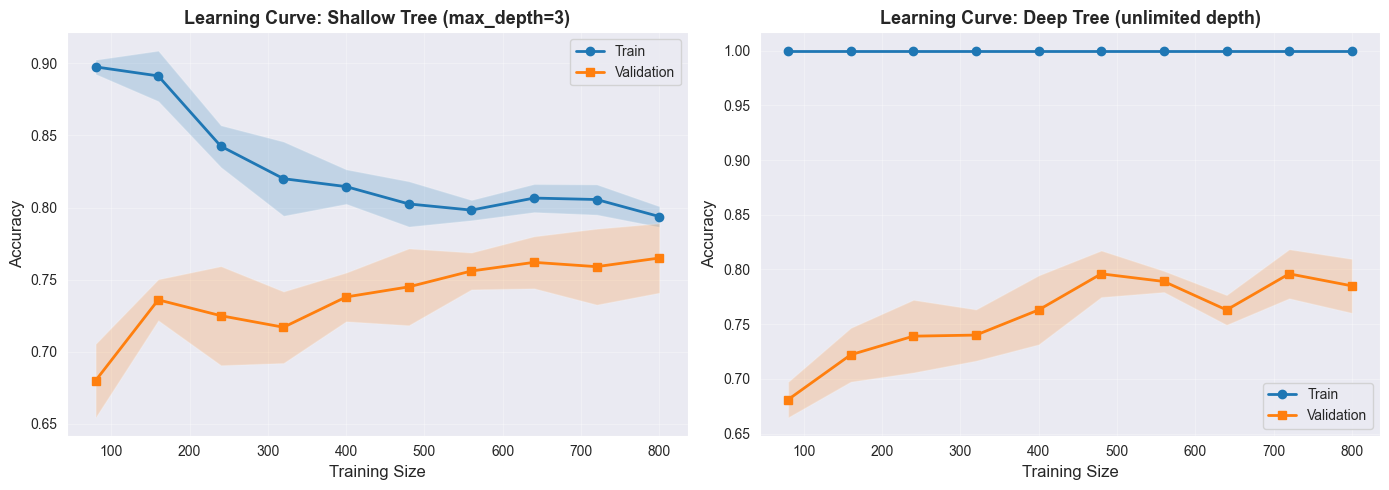

In [7]:
# Generate larger dataset
X_large, y_large = make_classification(n_samples=1000, n_features=20, 
                                      n_informative=15, n_redundant=5,
                                      random_state=42)

# Compare shallow vs deep tree
tree_shallow = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_deep = DecisionTreeClassifier(max_depth=None, random_state=42)

# Compute learning curves
train_sizes = np.linspace(0.1, 1.0, 10)

train_sizes_shallow, train_scores_shallow, val_scores_shallow = learning_curve(
    tree_shallow, X_large, y_large, train_sizes=train_sizes, cv=5, random_state=42
)

train_sizes_deep, train_scores_deep, val_scores_deep = learning_curve(
    tree_deep, X_large, y_large, train_sizes=train_sizes, cv=5, random_state=42
)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#Shallow tree
axes[0].plot(train_sizes_shallow, train_scores_shallow.mean(axis=1), 
            'o-', label='Train', linewidth=2)
axes[0].plot(train_sizes_shallow, val_scores_shallow.mean(axis=1),
            's-', label='Validation', linewidth=2)
axes[0].fill_between(train_sizes_shallow, 
                    train_scores_shallow.mean(axis=1) - train_scores_shallow.std(axis=1),
                    train_scores_shallow.mean(axis=1) + train_scores_shallow.std(axis=1),
                    alpha=0.2)
axes[0].fill_between(train_sizes_shallow,
                    val_scores_shallow.mean(axis=1) - val_scores_shallow.std(axis=1),
                    val_scores_shallow.mean(axis=1) + val_scores_shallow.std(axis=1),
                    alpha=0.2)
axes[0].set_xlabel('Training Size', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Learning Curve: Shallow Tree (max_depth=3)', 
                 fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Deep tree
axes[1].plot(train_sizes_deep, train_scores_deep.mean(axis=1),
            'o-', label='Train', linewidth=2)
axes[1].plot(train_sizes_deep, val_scores_deep.mean(axis=1),
            's-', label='Validation', linewidth=2)
axes[1].fill_between(train_sizes_deep,
                    train_scores_deep.mean(axis=1) - train_scores_deep.std(axis=1),
                    train_scores_deep.mean(axis=1) + train_scores_deep.std(axis=1),
                    alpha=0.2)
axes[1].fill_between(train_sizes_deep,
                    val_scores_deep.mean(axis=1) - val_scores_deep.std(axis=1),
                    val_scores_deep.mean(axis=1) + val_scores_deep.std(axis=1),
                    alpha=0.2)
axes[1].set_xlabel('Training Size', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Learning Curve: Deep Tree (unlimited depth)',
                 fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Interpretation:
- **Shallow tree**: Small gap between train/val → high bias, low variance
- **Deep tree**: Large gap between train/val → low bias, high variance (overfitting)
- **More data helps** reduce overfitting for deep trees

---
## Part 4: Pre-Pruning Best Practices

In [8]:
# Test multiple hyperparameter combinations
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy']
}

tree = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(tree, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print('='*60)
print('GRID SEARCH RESULTS')
print('='*60)
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best CV score: {grid_search.best_score_:.4f}')
print(f'Test score: {grid_search.score(X_test, y_test):.4f}')

GRID SEARCH RESULTS
Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 20}
Best CV score: 0.8905
Test score: 0.9111


---
## Summary

### Overfitting Signs:
1. Train accuracy >> Test accuracy
2. Very deep trees (> 10 levels)
3. Many leaf nodes
4. Complex, jagged decision boundaries

### Prevention Strategies:

#### Pre-Pruning (Early Stopping):
- **max_depth**: Limit tree depth (try 3-10)
- **min_samples_split**: Min samples to split (try 10-50)
- **min_samples_leaf**: Min samples per leaf (try 5-20)
- **max_leaf_nodes**: Limit total leaves
- **min_impurity_decrease**: Min improvement to split

#### Other Approaches:
- **More training data**: Helps deep trees generalize
- **Feature selection**: Remove irrelevant features
- **Ensemble methods**: Use Random Forests instead
- **Cross-validation**: Always validate hyperparameters

### Tuning Workflow:
1. Start with shallow tree (depth 3-5)
2. Check train vs test performance
3. If underfitting → increase complexity
4. If overfitting → add constraints
5. Use GridSearchCV for optimal hyperparameters

### Key Point:
"Decision trees are prone to overfitting without constraints. Pre-pruning using max_depth, min_samples_split, and min_samples_leaf prevents trees from memorizing training data. The key is finding the sweet spot: complex enough to capture patterns, simple enough to generalize. Use cross-validation to tune hyperparameters and always monitor the train-test gap."

---

**Decision Trees component complete!**